In [15]:
'''
    Extracted from PyTorch tutorial for Character Generation with GRU
    Included to generate Nepali Names
    
    Date - 11/29/2018
    
    Description:
    Simple Character level GRU network to Generate Nepali Names
    
    Thanks :
    https://github.com/FraLotito/pytorch-generating-names-rnn/blob/master/src/model.py
    https://github.com/rezkaaufar/Indonesian-News-Generation-RNN-Charlevel/blob/master/indonesian_news_charlevel.ipynb
'''

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

# To include devnagari letters
devnagari = ""
for i in range(2304, 2383):
    devnagari += chr(i)

all_letters = string.ascii_letters + " .,;'-" + devnagari
n_letters = len(all_letters) + 1 # Plus EOS marker

print(all_letters)
print(n_letters)

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii('ओयेश'))


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-ऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎ
138
# categories: 19 ['Spanish', 'Korean', 'French', 'Chinese', 'Italian', 'Russian', 'Nepali', 'Arabic', 'Dutch', 'Japanese', 'English', 'Polish', 'Vietnamese', 'German', 'Portuguese', 'Irish', 'Scottish', 'Greek', 'Czech']
ओयश


In [16]:
# Create a LSTM class and implement char-generation

# Here we define our model as a class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, batch_size=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.char_encoder = nn.Embedding(input_size, input_size)
        self.category_encoder = nn.Embedding(n_categories, n_categories)
        
        self.lstm = nn.GRU(input_size + n_categories, hidden_size, num_layers)
        
        self.decoder = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
        
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((input, category), 1)  
        
        input_combined = input_combined.unsqueeze(1) #seq_len, batch, input_size

        lstm_out, hidden = self.lstm(input_combined, hidden)

        output = self.decoder(lstm_out.view(-1, self.hidden_size))

        output = self.softmax(output)

        return output, hidden

In [17]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# Get a random category and random line from that category
def randomName(category='Nepali'):
    line = randomChoice(category_lines[category])
    return category, line

In [18]:
randomName()

('Nepali', 'बिनम')

In [19]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [20]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Make category, input, and target tensors from a random category, line pair
def mock_randomTrainingExample():
    category, line = randomName()
    print('Name: ',line)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [21]:
category_tensor, input_line_tensor, target_line_tensor = mock_randomTrainingExample()
print(target_line_tensor)
print(n_letters)

Name:  कजल
tensor([ 86, 108, 137])
138


In [22]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [23]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

hidden_size = 128

gru = RNN(n_letters, hidden_size, n_letters, num_layers=1)

optimizer = optim.Adam(gru.parameters(), learning_rate)

In [24]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = gru.init_hidden()

    loss = 0
    
    optimizer.zero_grad()
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = gru(category_tensor, input_line_tensor[i], hidden)
        
        loss += criterion(output, target_line_tensor[i])
        
    if loss == 0:
        print("Input line tensor size = ", input_line_tensor.size(0))
        print("Inside loss = ", loss)
        print(output)
        print(category_tensor)     


        
    loss.backward()
    
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [25]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter/n_iters * 100, loss))
        
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 59s (5000 5%) 2.0120
2m 6s (10000 10%) 2.9584
3m 20s (15000 15%) 2.0788
4m 35s (20000 20%) 1.5890
5m 47s (25000 25%) 1.6176
6m 50s (30000 30%) 1.5655
8m 0s (35000 35%) 1.3954
9m 10s (40000 40%) 1.7901
10m 12s (45000 45%) 1.0399
11m 17s (50000 50%) 2.5652
12m 20s (55000 55%) 0.7807
13m 30s (60000 60%) 1.3647
14m 36s (65000 65%) 2.5305
16m 2s (70000 70%) 0.6335
17m 22s (75000 75%) 1.9303
18m 34s (80000 80%) 1.6731
19m 35s (85000 85%) 0.9472
20m 52s (90000 90%) 0.5450
22m 5s (95000 95%) 0.1416
23m 20s (100000 100%) 0.7071


In [26]:
# Save torch model
torch.save(gru.state_dict(),f='char_gru_gen.model')

<IPython.core.display.Javascript object>


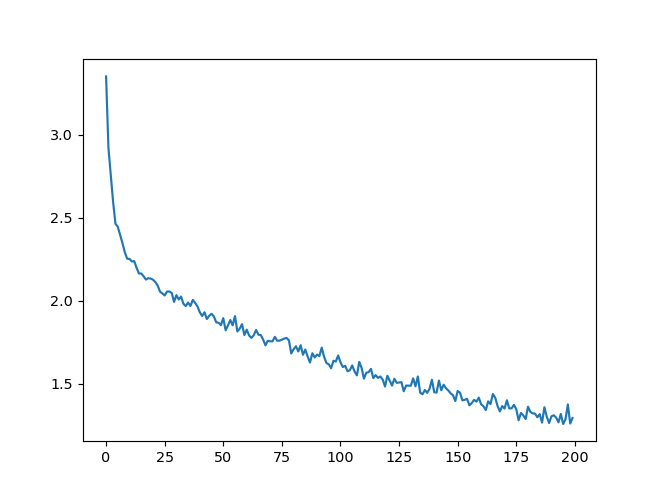

In [27]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [25]:
# Load model
gru = RNN(n_letters, hidden_size, n_letters)
gru.load_state_dict(torch.load('char_gru_gen.model'))

In [28]:
from torch.autograd import Variable

max_length = 20

#Sample from a category and  starting letter
def sample(category, start_letter = 'A'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = gru.init_hidden()
    
    output_name = start_letter
    
    for i in range(max_length):
        output, hidden = gru(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters-1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
            
        input = Variable(inputTensor(letter))
        
    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters = 'ABCDEF'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        

In [31]:
# nepali_letter = 'कखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहक्षत्रज्ञ'
samples('Nepali', 'अकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहक्षत्रज्ञ')

अनिश
करितिश
खम
गरिना
घिशव
ङनिता
चनता
छिशव
जन
झनिता
ञजन
टिता
ठनिता
डिशव
ढरिता
ण
तिशवान
थिन
दिपिका
धिर
निशव
परिता
फिशव
बिनित
भान
मनिन
योश
रिनचन
लोनी
विनिता
शरिका
षितिका
सबिन
हमराज
करितिश
्रिता
षितिका
तिशवान
्रिता
रिनचन
जन
्रिता
ञजन
